In [1]:
# Requirements
import optuna
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm

# Suppress Optuna's experimental warning for MedianPruner
warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

C:\Users\DAIICT I\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -----------------------
# 0) Housekeeping
# -----------------------
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior (slower but stable)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [3]:
# ----------------------------------------------------------------------------
# 1. Configuration Grid
# ----------------------------------------------------------------------------
class Config:
    """Centralized configuration for hyperparameters and settings."""
    # --- Data and Splitting ---
    FILE_PATH = r"C:\Users\DAIICT I\Desktop\Msc DS Sujal 202418017\Interval_Forecast_Multivariate\merged_df_final.csv"
    TARGET_COLUMN = 'Carbon_Price_USD'
    DATE_COLUMN = 'Date'
    VAL_SPLIT_DATE = '2024-04-01'
    
    # --- Optuna Hyperparameter Search Space ---
    N_TRIALS = 100  # Number of optimization trials
    WINDOW_SIZE_MIN = 2
    WINDOW_SIZE_MAX = 40
    GRU_HIDDEN_SIZES = [32, 64, 128] # Changed from LSTM
    NUM_GAUSSIANS_MIN = 2
    NUM_GAUSSIANS_MAX = 8
    NUM_GRU_LAYERS_MIN = 1 # Changed from LSTM
    NUM_GRU_LAYERS_MAX = 3 # Changed from LSTM
    DROPOUT_MIN = 0.0
    DROPOUT_MAX = 0.4
    LR_MIN = 1e-4
    LR_MAX = 1e-2

    # --- Final Training and Evaluation ---
    NUM_RUNS = 5  # Number of ensemble runs for stability check
    MAX_EPOCHS = 100
    BATCH_SIZE = 32
    CRPS_SAMPLES = 1000 # Number of samples for CRPS calculation

    # --- Prediction Interval Configuration (CHANGE THIS SECTION) ---
    LOWER_QUANTILE = 0.025
    UPPER_QUANTILE = 0.975

In [4]:
# ----------------------------------------------------------------------------
# 2. Device Configuration
# ----------------------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# ----------------------------------------------------------------------------
# 3. GruMDN Model Definition
# ----------------------------------------------------------------------------
class GruMDN(nn.Module):
    """GRU base with a Mixture Density Network head."""
    def __init__(self, input_size, gru_hidden_size, num_gru_layers, num_gaussians, dropout):
        super().__init__()
        self.gru = nn.GRU( # Changed from nn.LSTM to nn.GRU
            input_size=input_size,
            hidden_size=gru_hidden_size,
            num_layers=num_gru_layers,
            batch_first=True,
            dropout=dropout if num_gru_layers > 1 else 0
        )
        self.z_pi = nn.Linear(gru_hidden_size, num_gaussians)
        self.z_sigma = nn.Linear(gru_hidden_size, num_gaussians)
        self.z_mu = nn.Linear(gru_hidden_size, num_gaussians)

    def forward(self, x):
        gru_out, _ = self.gru(x) # GRU output format is compatible
        last_output = gru_out[:, -1, :]
        pi = F.softmax(self.z_pi(last_output), dim=1)
        sigma = F.softplus(self.z_sigma(last_output)) + 1e-6
        mu = self.z_mu(last_output)
        return pi, sigma, mu

In [6]:
# ----------------------------------------------------------------------------
# 4. Helper Functions
# ----------------------------------------------------------------------------
def create_sequences(features, target, window_size):
    """Creates sequences for true forecasting."""
    X_seq, y_seq = [], []
    for i in range(len(features) - window_size):
        X_seq.append(features[i:(i + window_size)])
        y_seq.append(target[i + window_size])
    return np.array(X_seq), np.array(y_seq)

def mdn_loss(pi, sigma, mu, y):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    log_prob = m.log_prob(y)
    weighted_log_prob = log_prob + torch.log(pi)
    log_sum_exp = torch.logsumexp(weighted_log_prob, dim=1)
    return -torch.mean(log_sum_exp)

def calculate_all_metrics(pi, sigma, mu, y_true_tensor, scaler_y, lower_quantile, upper_quantile, num_samples_crps):
    """Calculates PICP, MPIW, CRPS, and prediction bounds from MDN parameters."""
    with torch.no_grad():
        # --- PICP and MPIW Calculation ---
        effective_mu = torch.sum(pi * mu, dim=1)
        effective_var = torch.sum(pi * (sigma**2 + mu**2), dim=1) - effective_mu**2
        effective_sigma = torch.sqrt(effective_var + 1e-6)

        z_lower = norm.ppf(lower_quantile)
        z_upper = norm.ppf(upper_quantile)

        lower_scaled = effective_mu + z_lower * effective_sigma
        upper_scaled = effective_mu + z_upper * effective_sigma

        y_true_inv = scaler_y.inverse_transform(y_true_tensor.cpu().numpy()).flatten()
        lower_inv = scaler_y.inverse_transform(lower_scaled.cpu().numpy().reshape(-1, 1)).flatten()
        upper_inv = scaler_y.inverse_transform(upper_scaled.cpu().numpy().reshape(-1, 1)).flatten()
        
        is_inside = (y_true_inv >= lower_inv) & (y_true_inv <= upper_inv)
        picp = np.mean(is_inside) * 100
        mpiw = np.mean(upper_inv - lower_inv)

        # --- CRPS Calculation ---
        component_indices_1 = torch.multinomial(pi, num_samples_crps, replacement=True)
        mu_samples_1 = torch.gather(mu, 1, component_indices_1)
        sigma_samples_1 = torch.gather(sigma, 1, component_indices_1)
        samples_1 = torch.normal(mu_samples_1, sigma_samples_1).cpu().numpy()

        component_indices_2 = torch.multinomial(pi, num_samples_crps, replacement=True)
        mu_samples_2 = torch.gather(mu, 1, component_indices_2)
        sigma_samples_2 = torch.gather(sigma, 1, component_indices_2)
        samples_2 = torch.normal(mu_samples_2, sigma_samples_2).cpu().numpy()

        samples_inv_1 = scaler_y.inverse_transform(samples_1)
        samples_inv_2 = scaler_y.inverse_transform(samples_2)
        
        term1 = np.mean(np.abs(samples_inv_1 - y_true_inv.reshape(-1, 1)), axis=1)
        term2 = 0.5 * np.mean(np.abs(samples_inv_1 - samples_inv_2), axis=1)
        crps = np.mean(term1 - term2)

        return mpiw, picp, crps, lower_inv, upper_inv

In [7]:
# ----------------------------------------------------------------------------
# 5. Data Loading and Preprocessing
# ----------------------------------------------------------------------------
df = pd.read_csv(Config.FILE_PATH)
df[Config.DATE_COLUMN] = pd.to_datetime(df[Config.DATE_COLUMN])
df = df.sort_values(Config.DATE_COLUMN).fillna(method='ffill').reset_index(drop=True)

feature_cols = df.columns.drop([Config.DATE_COLUMN])

train_val_df = df[df[Config.DATE_COLUMN] < Config.VAL_SPLIT_DATE]
test_df = df[df[Config.DATE_COLUMN] >= Config.VAL_SPLIT_DATE]
val_split_index = int(len(train_val_df) * 0.9)
train_df = train_val_df[:val_split_index]
val_df = train_val_df[val_split_index:]

X_train_raw, y_train_raw = train_df[feature_cols].values, train_df[Config.TARGET_COLUMN].values.reshape(-1, 1)
X_val_raw, y_val_raw = val_df[feature_cols].values, val_df[Config.TARGET_COLUMN].values.reshape(-1, 1)
X_test_raw, y_test_raw = test_df[feature_cols].values, test_df[Config.TARGET_COLUMN].values.reshape(-1, 1)

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_x.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw)
X_val = scaler_x.transform(X_val_raw)
y_val = scaler_y.transform(y_val_raw)
X_test = scaler_x.transform(X_test_raw)
y_test = scaler_y.transform(y_test_raw)

C:\Users\DAIICT I\AppData\Local\Temp\ipykernel_27200\139681524.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.sort_values(Config.DATE_COLUMN).fillna(method='ffill').reset_index(drop=True)


In [8]:
# ----------------------------------------------------------------------------
# 6. Optuna Objective Function
# ----------------------------------------------------------------------------
def objective(trial):
    window_size = trial.suggest_int('window_size', Config.WINDOW_SIZE_MIN, Config.WINDOW_SIZE_MAX)
    num_gru_layers = trial.suggest_int('num_gru_layers', Config.NUM_GRU_LAYERS_MIN, Config.NUM_GRU_LAYERS_MAX)
    gru_hidden_size = trial.suggest_categorical('gru_hidden_size', Config.GRU_HIDDEN_SIZES)
    num_gaussians = trial.suggest_int('num_gaussians', Config.NUM_GAUSSIANS_MIN, Config.NUM_GAUSSIANS_MAX)
    dropout = trial.suggest_float('dropout', Config.DROPOUT_MIN, Config.DROPOUT_MAX)
    lr = trial.suggest_float('lr', Config.LR_MIN, Config.LR_MAX, log=True)

    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_val_seq, y_val_seq = create_sequences(X_val, y_val, window_size)

    if len(X_val_seq) == 0:
        raise optuna.exceptions.TrialPruned()

    X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val_seq, dtype=torch.float32).to(device)
    
    model = GruMDN(
        input_size=X_train_seq.shape[2], gru_hidden_size=gru_hidden_size,
        num_gru_layers=num_gru_layers, num_gaussians=num_gaussians, dropout=dropout
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=Config.BATCH_SIZE, shuffle=True)

    for epoch in range(Config.MAX_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pi, sigma, mu = model(xb)
            loss = mdn_loss(pi, sigma, mu, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            pi_val, sigma_val, mu_val = model(X_val_tensor)
            mpiw, picp, _, _, _ = calculate_all_metrics(
                pi_val, sigma_val, mu_val, y_val_tensor, scaler_y,
                lower_quantile=0.025, upper_quantile=0.975,
                num_samples_crps=100
            )
        
        target_coverage = 95.0
        score = 1000.0 + (target_coverage - picp) if picp < (target_coverage - 1.0) else mpiw
        
        trial.report(score, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return score

In [9]:
# ----------------------------------------------------------------------------
# 7. Run Hyperparameter Optimization
# ----------------------------------------------------------------------------
print(f"\n{'='*20} STARTING HYPERPARAMETER OPTIMIZATION {'='*20}")
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=Config.N_TRIALS)

best_params = study.best_params
optimal_epochs = study.best_trial.last_step + 1
best_window_size = best_params['window_size']

print("\n--- Optuna Study Complete ---")
print(f"Best Score (Validation): {study.best_value:.4f}")
print("Best Hyperparameters:", best_params)
print(f"Optimal epochs found: {optimal_epochs}")


[I 2025-08-23 22:48:14,338] A new study created in memory with name: no-name-57b37345-8bad-413f-9664-a54c3c01afc0



==================== STARTING HYPERPARAMETER OPTIMIZATION ====================


[I 2025-08-23 22:48:20,405] Trial 0 finished with value: 1052.8125 and parameters: {'window_size': 20, 'num_gru_layers': 3, 'gru_hidden_size': 32, 'num_gaussians': 5, 'dropout': 0.18275060543445432, 'lr': 0.00014426495505996003}. Best is trial 0 with value: 1052.8125.
[I 2025-08-23 22:48:26,647] Trial 1 finished with value: 1070.438596491228 and parameters: {'window_size': 27, 'num_gru_layers': 2, 'gru_hidden_size': 64, 'num_gaussians': 5, 'dropout': 0.13735444972001223, 'lr': 0.005113432080623771}. Best is trial 0 with value: 1052.8125.
[I 2025-08-23 22:48:30,897] Trial 2 finished with value: 12.355700492858887 and parameters: {'window_size': 2, 'num_gru_layers': 1, 'gru_hidden_size': 128, 'num_gaussians': 4, 'dropout': 0.20177971743583806, 'lr': 0.00028151511985604146}. Best is trial 2 with value: 12.355700492858887.
[I 2025-08-23 22:48:35,011] Trial 3 finished with value: 1007.9032258064516 and parameters: {'window_size': 22, 'num_gru_layers': 1, 'gru_hidden_size': 32, 'num_gaussian


--- Optuna Study Complete ---
Best Score (Validation): 7.5006
Best Hyperparameters: {'window_size': 10, 'num_gru_layers': 1, 'gru_hidden_size': 128, 'num_gaussians': 6, 'dropout': 0.010962075667596244, 'lr': 0.0005017141989478682}
Optimal epochs found: 100


In [10]:
# ----------------------------------------------------------------------------
# 8. Train and Evaluate Ensemble with BEST Hyperparameters
# ----------------------------------------------------------------------------
all_run_results = []

X_full_train_raw = np.concatenate((X_train_raw, X_val_raw), axis=0)
y_full_train_raw = np.concatenate((y_train_raw, y_val_raw), axis=0)
X_full_train = scaler_x.transform(X_full_train_raw)
y_full_train = scaler_y.transform(y_full_train_raw)

X_full_train_seq, y_full_train_seq = create_sequences(X_full_train, y_full_train, best_window_size)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, best_window_size)

X_full_train_tensor = torch.tensor(X_full_train_seq, dtype=torch.float32)
y_full_train_tensor = torch.tensor(y_full_train_seq, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device)

train_loader = DataLoader(TensorDataset(X_full_train_tensor, y_full_train_tensor), batch_size=Config.BATCH_SIZE, shuffle=True)

for i in range(Config.NUM_RUNS):
    print(f"\n{'='*20} STARTING STABILITY RUN {i+1}/{Config.NUM_RUNS} {'='*20}")
    
    final_model = GruMDN(
        input_size=X_full_train_seq.shape[2],
        gru_hidden_size=best_params['gru_hidden_size'],
        num_gru_layers=best_params['num_gru_layers'],
        num_gaussians=best_params['num_gaussians'],
        dropout=best_params['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['lr'])

    print(f"Training final model for {optimal_epochs} epochs...")
    for epoch in range(optimal_epochs):
        final_model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            pi, sigma, mu = final_model(xb)
            loss = mdn_loss(pi, sigma, mu, yb)
            loss.backward()
            optimizer.step()

    print(f"Evaluating Run {i+1} on test set...")
    final_model.eval()
    with torch.no_grad():
        pi_test, sigma_test, mu_test = final_model(X_test_tensor)
        
        mpiw, picp, crps, lower, upper = calculate_all_metrics(
            pi_test, sigma_test, mu_test, y_test_tensor, scaler_y,
            lower_quantile=Config.LOWER_QUANTILE, 
            upper_quantile=Config.UPPER_QUANTILE,
            num_samples_crps=Config.CRPS_SAMPLES
        )
        coverage = (Config.UPPER_QUANTILE - Config.LOWER_QUANTILE) * 100
        print(f"  Interval [{Config.LOWER_QUANTILE}, {Config.UPPER_QUANTILE}] ({coverage:.1f}%) -> PICP: {picp:.2f}%, MPIW: {mpiw:.4f}, CRPS: {crps:.4f}")

    all_run_results.append({
        'run': i+1, 'mpiw': mpiw, 'picp': picp, 'crps': crps,
        'lower_bound': lower, 'upper_bound': upper, 'params': best_params
    })


==================== STARTING STABILITY RUN 1/5 ====================
Training final model for 100 epochs...
Evaluating Run 1 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 97.47%, MPIW: 7.9649, CRPS: 0.9876

==================== STARTING STABILITY RUN 2/5 ====================
Training final model for 100 epochs...
Evaluating Run 2 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 98.73%, MPIW: 8.4784, CRPS: 1.1274

==================== STARTING STABILITY RUN 3/5 ====================
Training final model for 100 epochs...
Evaluating Run 3 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 96.20%, MPIW: 8.0310, CRPS: 1.0249

==================== STARTING STABILITY RUN 4/5 ====================
Training final model for 100 epochs...
Evaluating Run 4 on test set...
  Interval [0.025, 0.975] (95.0%) -> PICP: 92.41%, MPIW: 7.0358, CRPS: 1.0638

==================== STARTING STABILITY RUN 5/5 ====================
Training final model for 100 epochs...
Evaluating Run 


==================== ANALYSIS ACROSS ALL 5 RUNS ====================

Best hyperparameters saved to 'GRU_MDN_Forecasting_best_hyperparameters.csv'

--- Results from Each Run (Interval: [0.025, 0.975]) ---
       mpiw     picp    crps
run                         
1    7.9649  97.4684  0.9876
2    8.4784  98.7342  1.1274
3    8.0310  96.2025  1.0249
4    7.0358  92.4051  1.0638
5    6.8110  91.1392  1.0570

--- Statistical Summary ---
         mpiw     picp    crps
count  5.0000   5.0000  5.0000
mean   7.6642  95.1899  1.0521
std    0.7090   3.2765  0.0518
min    6.8110  91.1392  0.9876
25%    7.0358  92.4051  1.0249
50%    7.9649  96.2025  1.0570
75%    8.0310  97.4684  1.0638
max    8.4784  98.7342  1.1274

Generating and saving the summary plot...


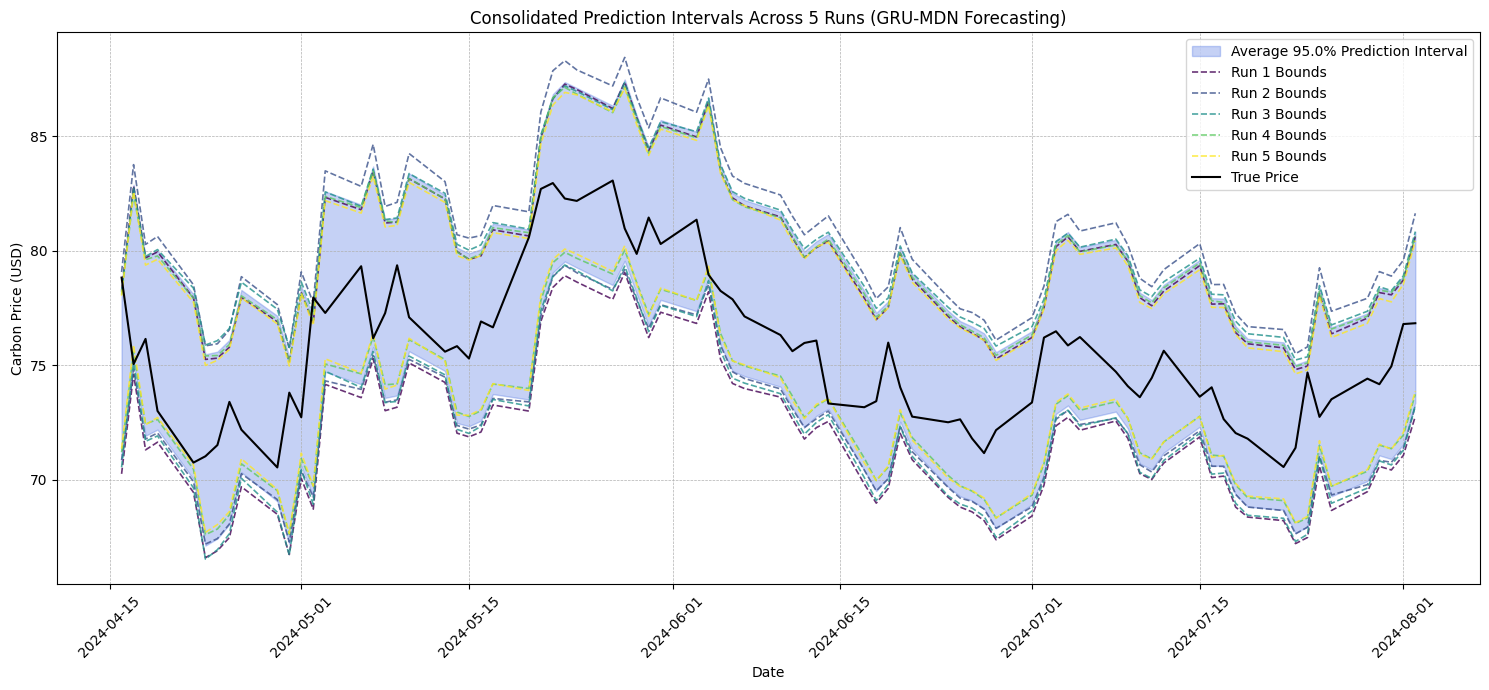


Summary plot saved to 'GRU_MDN_Forecasting_Multivariate.png'


In [11]:
# ----------------------------------------------------------------------------
# 9. FINAL ANALYSIS, SAVING, AND PLOTTING
# ----------------------------------------------------------------------------
print(f"\n{'='*20} ANALYSIS ACROSS ALL {Config.NUM_RUNS} RUNS {'='*20}")

params_df = pd.DataFrame([run['params'] for run in all_run_results])
params_df.insert(0, 'run', range(1, Config.NUM_RUNS + 1))
params_df.to_csv('GRU_MDN_Forecasting_best_hyperparameters.csv', index=False)
print("\nBest hyperparameters saved to 'GRU_MDN_Forecasting_best_hyperparameters.csv'")

metrics_df = pd.DataFrame(all_run_results).drop(columns=['params', 'lower_bound', 'upper_bound']).set_index('run')

print(f"\n--- Results from Each Run (Interval: [{Config.LOWER_QUANTILE}, {Config.UPPER_QUANTILE}]) ---")
print(metrics_df.round(4))

print("\n--- Statistical Summary ---")
print(metrics_df.describe().round(4))

print("\nGenerating and saving the summary plot...")
plt.figure(figsize=(15, 7))

lower_bounds = np.array([run['lower_bound'] for run in all_run_results])
upper_bounds = np.array([run['upper_bound'] for run in all_run_results])
avg_lower_bound = lower_bounds.mean(axis=0)
avg_upper_bound = upper_bounds.mean(axis=0)

plot_dates = test_df[Config.DATE_COLUMN].values[best_window_size:]
y_test_raw_plot = scaler_y.inverse_transform(y_test_seq)

coverage = (Config.UPPER_QUANTILE - Config.LOWER_QUANTILE) * 100
plt.fill_between(
    plot_dates, avg_lower_bound, avg_upper_bound, 
    color='royalblue', alpha=0.3, label=f'Average {coverage:.1f}% Prediction Interval'
)

colors = plt.cm.viridis(np.linspace(0, 1, Config.NUM_RUNS))
for run_index, run_data in enumerate(all_run_results):
    plt.plot(plot_dates, run_data['lower_bound'], color=colors[run_index], linestyle='--', linewidth=1.2, alpha=0.8)
    plt.plot(plot_dates, run_data['upper_bound'], color=colors[run_index], linestyle='--', linewidth=1.2, alpha=0.8, label=f'Run {run_index+1} Bounds')

plt.plot(plot_dates, y_test_raw_plot, color='black', linewidth=1.5, label='True Price')

plt.title(f'Consolidated Prediction Intervals Across {Config.NUM_RUNS} Runs (GRU-MDN Forecasting)')
plt.xlabel('Date')
plt.ylabel('Carbon Price (USD)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('GRU_MDN_Forecasting_Multivariate.png', dpi=300)
plt.show()
print("\nSummary plot saved to 'GRU_MDN_Forecasting_Multivariate.png'")